In [ ]:
#%%

# 0 impots
"""A2_GenerativeModels.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/16j1EOOp_2butQUNu1EV97VL6a5SioDwt

# Introduction to Deep Learning

<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 1, Part 3: Generative Models** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">


In this notebook we are going to cover two generative models for generating novel images:

1. Variational Autoencoders (**VAEs**)
2. Generative adversarial networks (**GANs**)


<img src="https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png" width="500">


Your main goal will be to retrain these models on a dataset of your choice and do some experiments on the learned latent space.

You should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.
"""

# !pip install 'tensorflow[and-gpu]'==2.14 ##

from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-12-09 11:22:59.185976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 11:22:59.195295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 11:22:59.203668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 11:22:59.206120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 11:22:59.213187: I tensorflow/core/platform/cpu_feature_guar

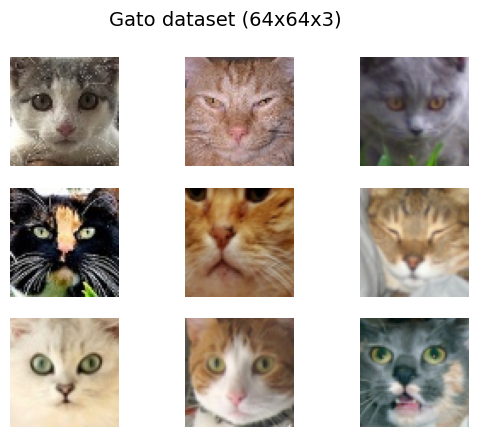

In [ ]:
#%%

# 1 data
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True) ## If you want to use your google drive

# !wget https://surfdrive.surf.nl/files/index.php/s/62Lnr1AtGe9b0v9/download -O face_dataset_64x64.npy

"""
### Dataset

This dataset is called [Flickr-Faces-HQ Dataset](https://github.com/NVlabs/ffhq-dataset). Here we will use a downsampled version of it (64x64x3) that will speed up all the experiments. [Download](https://surfdrive.surf.nl/files/index.php/s/LXBrnGGvUISlckW).

After downloading you should copy it to your google drive's main directory (or modify the code to load it from elsewhere).

After running the notebook on this default dataset you then need to find a dataset of your own."""

def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues, you can  change this value
    X = np.load('images_64x64.npy',  fix_imports=True,encoding='latin1')[:20000, :, :, :]
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='Gato dataset (64x64x3)', n=3)

In [ ]:
#%%

# 2 model
"""## 2.1. Introduction

The generative models that we are going to cover both have the following components:

1. A downsampling architecture (encoder in case of VAE, and discriminator in case of GAN) to either extract features from the data or model its distribution.
2. An upsampling architecture (decoder for VAE, generator for GAN) that will use some kind of latent vector to generate new samples that resemble the data that it was trained on.

Since we are going to be dealing with images, we are going to use convolutional networks for upsampling and downsampling, similar to what you see below.

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png" width="500">


#### Code for building these components:
"""

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    input = tf.keras.Input(shape=in_shape)
    x = Conv2D(filters=filters, name='enc_input', **default_args)(input)

    for _ in range(n_downsampling_layers):
        x = Conv2D(**default_args, filters=filters)(x)

    x = Flatten()(x)
    x = Dense(out_shape, activation=out_activation, name='enc_output')(x)

    model = tf.keras.Model(inputs=input, outputs=x, name='Encoder')

    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """
    input = tf.keras.Input(shape=(latent_dim,))
    x = Dense(4 * 4 * 64, input_dim=latent_dim, name='dec_input')(input)
    x = Reshape((4, 4, 64))(x) # This matches the output size of the downsampling architecture

    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        x = Conv2DTranspose(filters=filters, **default_args)(x)

    # This last convolutional layer converts back to 3 channel RGB image
    x = Conv2D(filters=3, kernel_size=(3,3), padding='same', activation=activation_out, name='dec_output')(x)

    model = tf.keras.Model(inputs=input, outputs=x, name='Decoder')
    model.summary()
    return model

I0000 00:00:1733739789.140364  949552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733739789.171727  949552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733739789.171825  949552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733739789.173053  949552 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_input (Conv2D)              │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_output (Dense)              │ (None, 512)            │       262,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,576 (3.27 MB)

 Trainable params: 856,576 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

/vol/home/s4398831/workspace/leiden/S1/IDL/2024/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_input (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Conv2D)             │ (None, 64, 64, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,379 (3.99 MB)

 Trainable params: 1,045,379 (3.99 MB)

 Non-trainable params: 0 (0.00 B)


Epoch:  0


I0000 00:00:1733739791.977970  949679 service.cc:146] XLA service 0x7a14c0015920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733739791.977989  949679 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-09 11:23:12.015907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 11:23:12.190406: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-09 11:23:12.612873: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_674', 20 bytes spill stores, 20 bytes spill loads

2024-12-09 11:23:12.831652: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in functio

  6/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6922

I0000 00:00:1733739798.042168  949679 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6324

2024-12-09 11:23:26.563807: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1257', 8 bytes spill stores, 8 bytes spill loads

2024-12-09 11:23:26.620803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1257', 32 bytes spill stores, 32 bytes spill loads

2024-12-09 11:23:26.761122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1257', 32 bytes spill stores, 32 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.6321
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


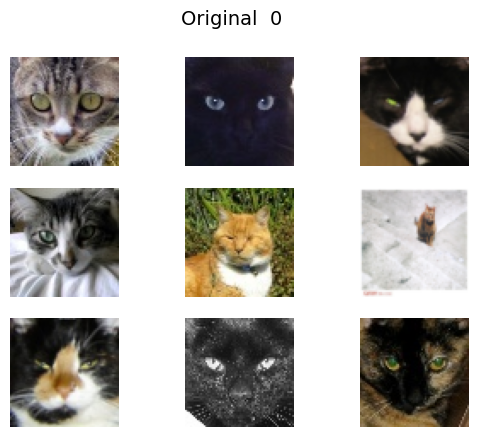

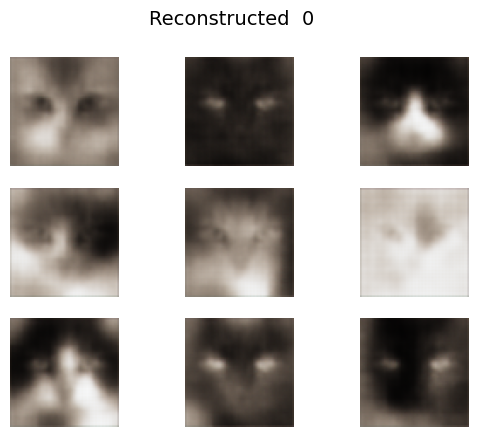


Epoch:  1
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


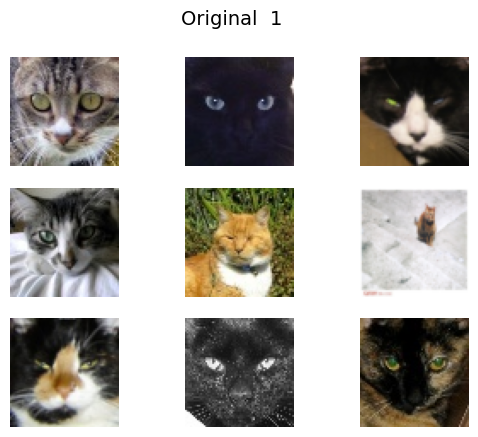

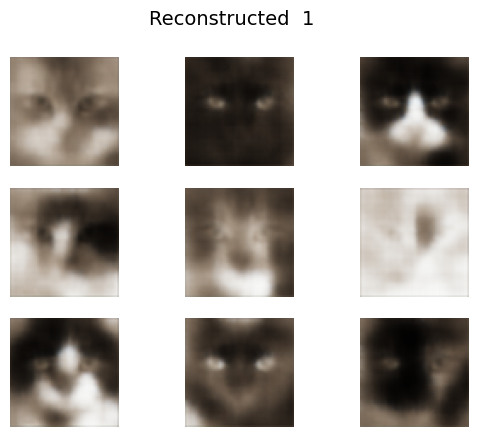


Epoch:  2
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


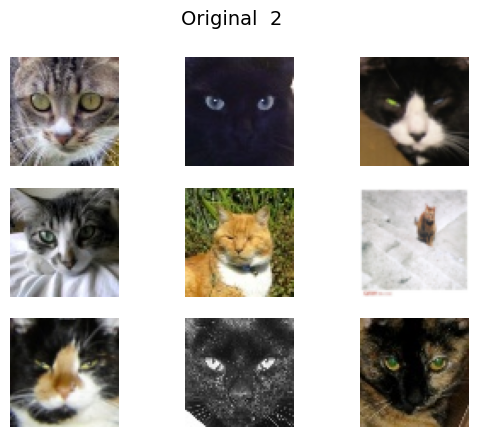

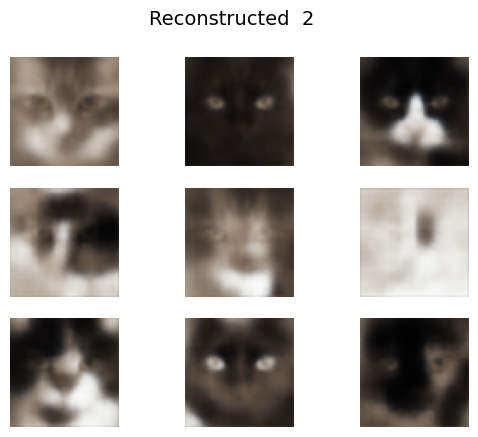


Epoch:  3
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


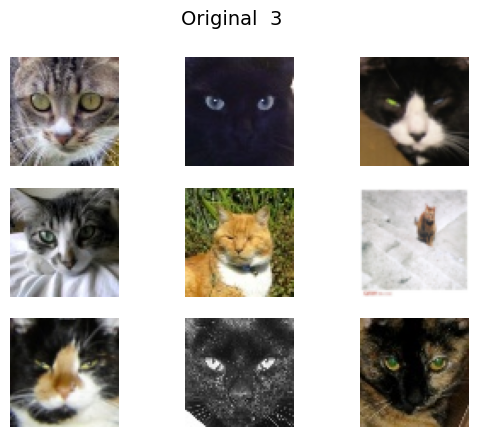

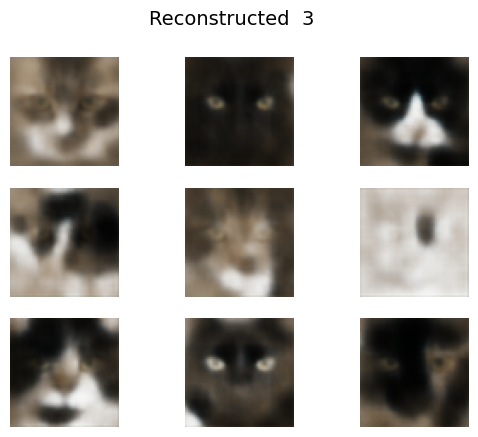


Epoch:  4
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5620
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


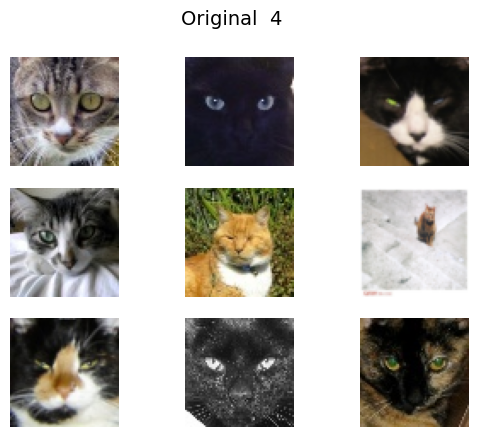

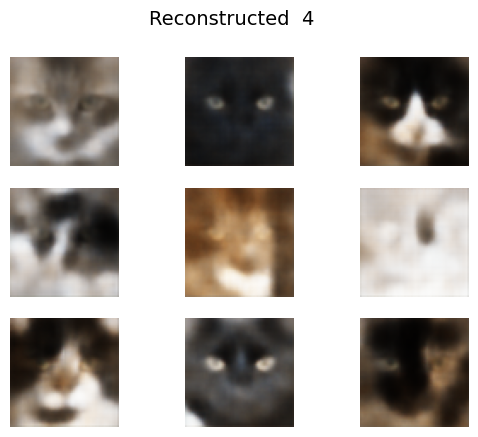


Epoch:  5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


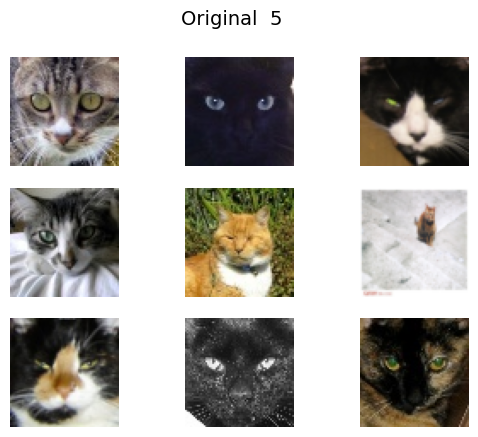

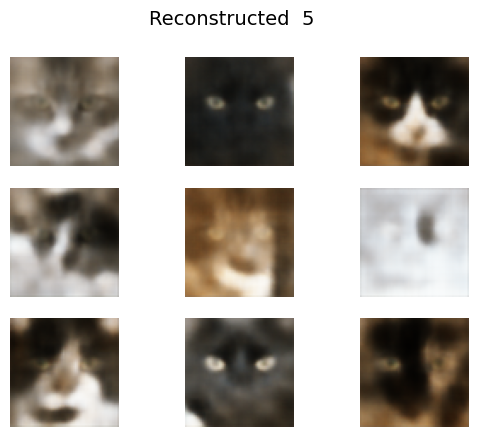


Epoch:  6
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


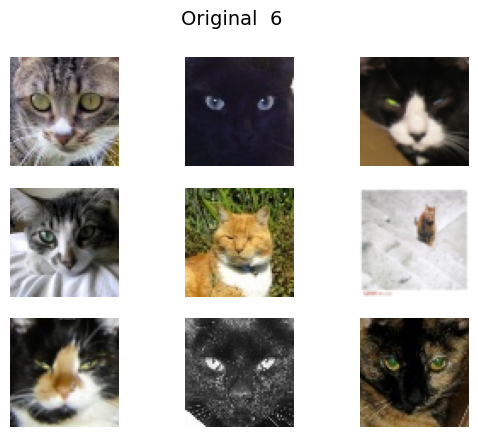

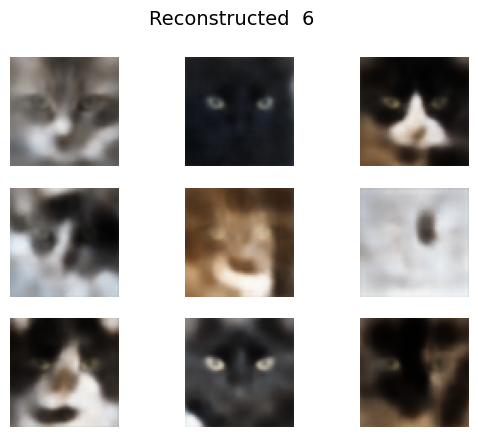


Epoch:  7
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


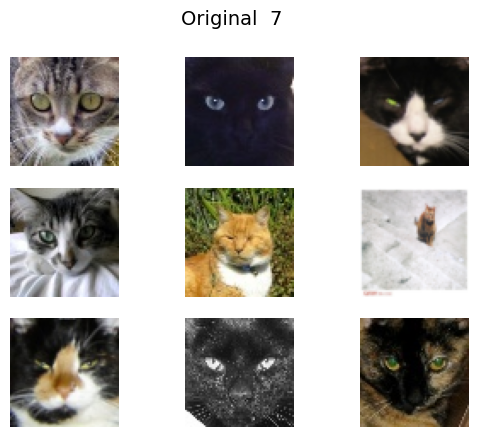

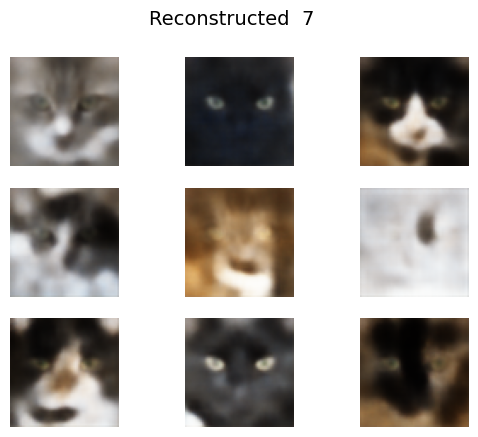


Epoch:  8
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


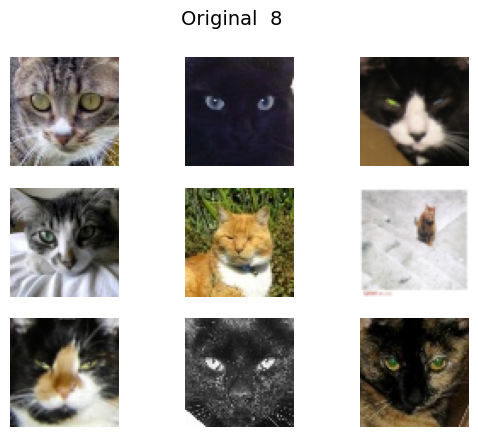

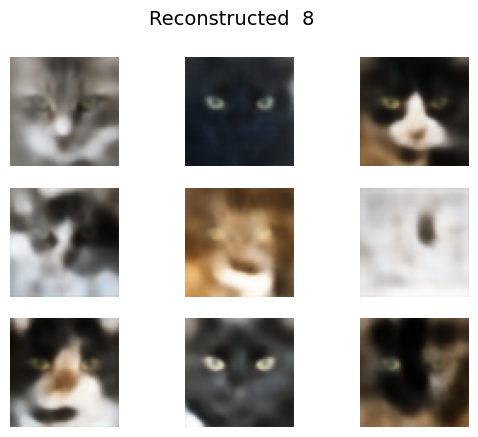


Epoch:  9
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.5540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


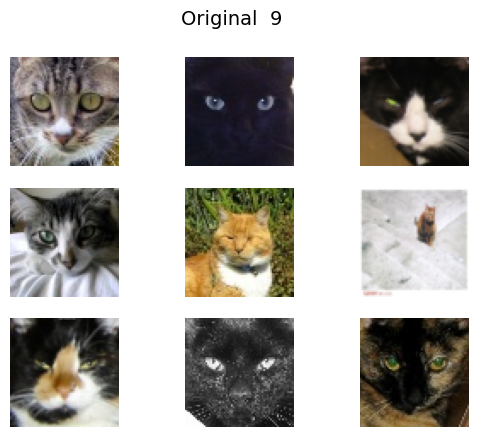

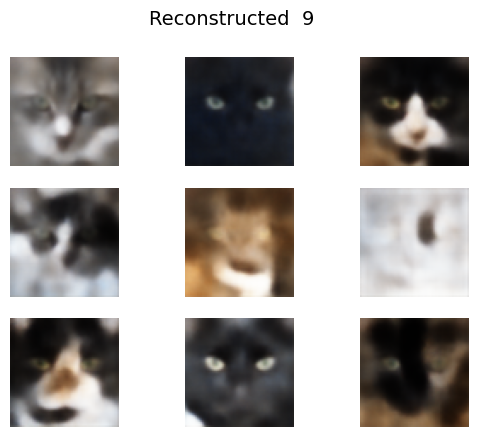

In [ ]:
#%%

# CAE example
"""### Convolutional Autoencoder example

Using these two basic building blocks we can now build a Convolutional Autoencoder (CAE).

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" width="500">



Even though it's not a generative model, CAE is a great way to illustrate how these two components (convolutional and deconvolutional networks) can be used together to reconstruct images.

You can view such model as a compression/dimensionality reduction method as each image gets compressed to a vector of 256 numbers by the encoder and gets decompressed back into an image using the decoder network.
"""

def build_convolutional_autoencoder(data_shape, latent_dim, filters=128):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim, filters=filters)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)

    # We connect encoder and decoder into a single model
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Binary crossentropy loss - pairwise comparison between input and output pixels
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

    return autoencoder


# Defining the model dimensions and building it
image_size = dataset.shape[1:]
latent_dim = 512
num_filters = 128
cae = build_convolutional_autoencoder(image_size, latent_dim, num_filters)


## Training the Convolutional autoencoder to reconstruct images
for epoch in range(10):
    print('\nEpoch: ', epoch)

    # Note that (X=y) when training autoencoders!
    # In this case we only care about qualitative performance, we don't split into train/test sets
    cae.fit(x=dataset, y=dataset, epochs=1, batch_size=64)
    idx = 18653
    samples = dataset[idx:idx+9]
    reconstructed = cae.predict(samples)
    grid_plot(samples, epoch, name='Original', n=3, save=False)
    grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

In [ ]:
#%% extract CAE encoder

encoder = cae.layers[0]
z = encoder.predict(dataset[:64])
m,s= np.array(z).mean(),np.array(z).std()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


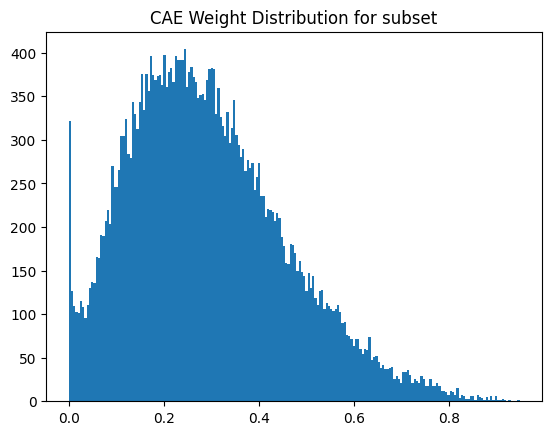

In [ ]:
#%% 

# get distribution
vals = np.array(z).flatten()
plt.hist(vals,bins=200)
plt.title("CAE Weight Distribution for subset")
# plt.show()
plt.savefig("CAE_sample_dist.png")

In [ ]:
m

0.29284754

In [ ]:
s

0.16443728

In [ ]:
random_data = 0.8*np.random.normal(m,s,size=(9,*input_shape))

In [ ]:
#%% extract decoder

decoder = cae.layers[1]
input_shape = decoder.input_shape[1:]
# decoder.summary()
random_data = 0.8*np.random.normal(m,s,size=(9,*input_shape))
idx = random_data<0
random_data[idx]=0

(array([170.,   9.,  11.,  12.,   8.,  12.,  13.,  12.,  16.,  12.,  14.,
         21.,  17.,  29.,  19.,  21.,  25.,  21.,  24.,  27.,  21.,  23.,
         30.,  27.,  19.,  23.,  31.,  32.,  33.,  31.,  35.,  28.,  36.,
         36.,  34.,  42.,  28.,  31.,  41.,  28.,  42.,  53.,  59.,  61.,
         37.,  38.,  54.,  44.,  36.,  39.,  53.,  54.,  48.,  53.,  56.,
         52.,  41.,  53.,  46.,  55.,  62.,  56.,  54.,  45.,  60.,  60.,
         43.,  55.,  56.,  56.,  62.,  66.,  44.,  49.,  55.,  45.,  52.,
         56.,  53.,  65.,  48.,  39.,  37.,  43.,  42.,  45.,  43.,  39.,
         46.,  31.,  39.,  28.,  36.,  45.,  40.,  26.,  35.,  32.,  31.,
         31.,  30.,  28.,  26.,  25.,  28.,  30.,  23.,  23.,  21.,  14.,
         28.,  17.,  22.,  16.,  12.,  12.,  20.,  21.,  21.,  11.,   6.,
         11.,  13.,   8.,   6.,  10.,  15.,  11.,   9.,  10.,   9.,  12.,
         11.,   4.,   8.,   9.,   6.,   8.,   7.,   5.,   9.,   5.,   6.,
          9.,   3.,   3.,   4.,   1., 

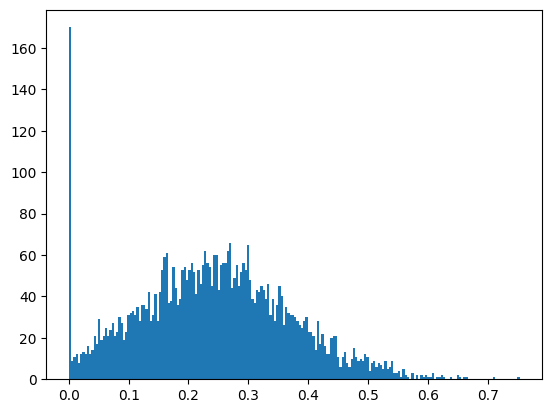

In [ ]:
#%%

plt.hist(np.array(random_data).flatten(),bins=200)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


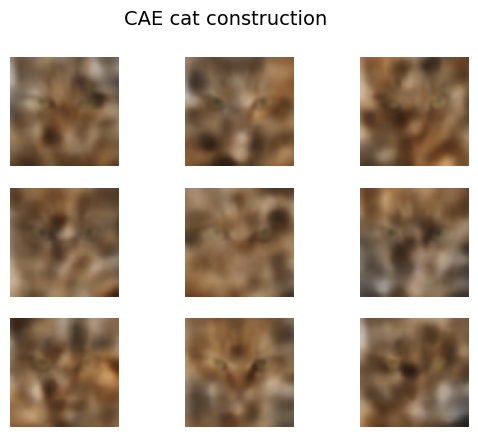

In [ ]:
#%%

pred = decoder.predict(random_data)
grid_plot(pred[:9],name="CAE cat construction")